## Caso de estudio 3.

Importamos las librerías necesarias

In [250]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, MeanShift, DBSCAN, Birch, AgglomerativeClustering, estimate_bandwidth
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from math import floor

import seaborn as sns

In [251]:
def imputar_vacios(df):
    data = df
    data = data[data["Type"].notnull() & (data["Type"] != "")]
    data["Type"] = data["Type"].map({"hotel": 1, "apartamento": 0})
    return data.fillna(data.mean())

In [252]:
def filtrar_valores(df):
    data = df
    # return data[(data["Number of views"] >= 30) & (data["Rating"] >= 5) & (data["Distance"] <= 1500)]
    return data[(data["Price avg"] <= 400) & (data["Rating"] != 0) & (data["Distance"] <= 20000)]
# & data.Rating != 0

In [253]:
def norm_to_zero_one(df): # Normalizar datos
    """Normaliza un DataFrame entre 0 y 1, devuelve los datos normalizados junto con los mínimos y máximos."""
    min_vals = df.min()
    max_vals = df.max()
    norm_data = (df - min_vals) / (max_vals - min_vals)
    return norm_data, min_vals, max_vals

In [254]:
def denorm_from_zero_one(norm_data, min_vals, max_vals): # Función para desnormalizar datos
    """Desnormaliza un DataFrame desde 0-1 usando los valores mínimos y máximos."""
    denorm_data = norm_data * (max_vals - min_vals) + min_vals
    return denorm_data

In [255]:
def gen_heatmap(centers_desnormal):
    centers = (centers_desnormal - centers_desnormal.min()) / (
        centers_desnormal.max() - centers_desnormal.min()
    )
    
    plt.figure()
    centers.index += 1
    plt.figure()
    hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
    hm.set_ylim(len(centers),0)
    hm.figure.set_size_inches(15,15)
    centers.index -= 1

In [256]:
def gen_heatmap_2(data, labels, method="mean"):

    # Crear un DataFrame con etiquetas de clusters
    data_with_labels = data.copy()
    data_with_labels["cluster"] = labels

    # Filtrar puntos que no son ruido (-1)
    data_clusters = data_with_labels[data_with_labels["cluster"] != -1]

    # Calcular resumen (media o mediana) de cada variable por cluster
    if method == "mean":
        cluster_summary = data_clusters.groupby("cluster").mean()
    elif method == "median":
        cluster_summary = data_clusters.groupby("cluster").median()
    else:
        raise ValueError("El método debe ser 'mean' o 'median'.")

    # Desnormalizar los datos para anotaciones
    cluster_summary_denorm = denorm_from_zero_one(cluster_summary, min_vals, max_vals)

    # Generar el heatmap
    plt.figure()
    cluster_summary.index += 1  # Ajustar índices para que empiecen en 1
    plt.figure()
    hm = sns.heatmap(cluster_summary, cmap="YlGnBu", annot=cluster_summary_denorm, fmt='.3f', annot_kws={"fontsize":18})
    hm.set_ylim(len(cluster_summary), 0)
    hm.figure.set_size_inches(15,15)
    cluster_summary.index -= 1

In [257]:
def gen_pairplot(df): # Generar un pairplot
    plt.figure()
    sns.set()
    variables = list(df)
    variables.remove("Cluster")
    df["Cluster"] += 1
    sns_plot = sns.pairplot(df, 
                            vars=variables, 
                            hue="Cluster", 
                            palette="pastel", 
                            plot_kws={"s": 25}, 
                            diag_kind="hist")
    
    df["Cluster"] -= 1
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03)
    sns_plot.fig.set_size_inches(15,15)
    plt.show()

In [258]:
def gen_boxplot(data, clusters):
    # Agregar los clusters como columna al DataFrame
    data_with_clusters = data.copy()
    
    # Configurar estilo de Seaborn
    sns.set(style="darkgrid", palette="muted", font_scale=1)

    # Identificar las variables numéricas
    variables = data.columns[:-1]
    n_clusters = len(set(clusters))
    n_rows = n_clusters
    n_cols = len(variables)

    # Calcular los rangos globales de cada variable
    variable_ranges = {var: (data[var].min(), data[var].max()) for var in variables}

    # Crear subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharey='row')

    # Asegurarse de que axes sea un arreglo bidimensional
    if n_clusters == 1:
        axes = [axes]  # Caso con un solo cluster
    if n_cols == 1:
        axes = [[ax] for ax in axes]  # Caso con una sola variable

    # Generar boxplots para cada cluster y variable con ejes uniformes
    for i, cluster in enumerate(sorted(data_with_clusters['Cluster'].unique())):
        cluster_data = data_with_clusters[data_with_clusters['Cluster'] == cluster]
        for j, variable in enumerate(variables):
            sns.boxplot(
                x=cluster_data[variable],
                ax=axes[i][j],
                color=sns.color_palette("muted")[i % len(sns.color_palette("muted"))]
            )
            axes[i][j].set(title=variable, ylabel=f"Cluster {cluster}")
            axes[i][j].set(xlabel="")
            # Fijar el rango global en el eje X para cada variable
            axes[i][j].set_xlim(variable_ranges[variable])

    # Ajustar diseño
    fig.tight_layout()
    fig.suptitle("Boxplots por Clusters y Variables (Rango Uniforme)", fontsize=16, y=1.02)
    plt.show()

In [259]:
def gen_dendogram(df):
    Z = linkage(df, method='single')
    
    plt.figure(figsize=(12, 8))
    dendrogram(
        Z,
        orientation="left",                    # Rotar para tener el estilo horizontal
        truncate_mode="lastp",  # Mostrar solo los últimos clusters fusionados
        p=10,
        leaf_rotation=0,                        # Rotación de las etiquetas
        leaf_font_size=10,                      # Tamaño de la fuente de las etiquetas
        show_contracted=True                    # Mostrar contracción de clusters
    )

    plt.title("Dendrograma con Enlace Simple", fontsize=16)
    plt.xlabel("Distancia")
    plt.ylabel("Índice de Muestra")
    plt.tight_layout() 
    plt.show()

In [260]:
def generar_metricas(df, clusters):
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    muestra_silhouette = 0.2 if (len(df) > 10000) else 1.0
    print("Silhouette")
    silhouette = silhouette_score(df, clusters, metric='euclidean', sample_size=floor(muestra_silhouette*len(df)), random_state=123456) if len(set(clusters)) > 1 else np.nan
    print("Calinski_harabasz")
    calinski_harabasz = calinski_harabasz_score(df, clusters) if len(set(clusters)) > 1 else np.nan
    print("Davies_Bouldin")
    davies_bouldin = davies_bouldin_score(df, clusters) if len(set(clusters)) > 1 else np.nan
    return n_clusters, silhouette, calinski_harabasz, davies_bouldin

In [261]:
def barras_clusters(clusters):
    clusters, counts = np.unique(clusters, return_counts=True)
    cluster_counts = pd.DataFrame({'Cluster': clusters, 'Count': counts}).sort_values(by="Cluster")
    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_counts['Cluster'], cluster_counts['Count'], color="skyblue", edgecolor="skyblue")
    plt.xticks(cluster_counts['Cluster'], labels=[f"Cluster {int(c)}" for c in cluster_counts['Cluster']])
    plt.xlabel("Clusters", fontsize=12)
    plt.ylabel("Cantidad de Datos", fontsize=12)
    plt.title("Distribución de Datos por Cluster", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Conseguimos los datos del CSV

In [262]:
datos = pd.read_csv('alojamientos_booking_Granada_2024.csv',sep= ';', encoding="iso-8859-1")
print(datos.describe())

            Guests    Price avg  Ranking position avg  Number of views  \
count  2269.000000  2269.000000           2269.000000      2269.000000   
mean      5.956809   501.163067            209.781842        85.719260   
std       2.069320   399.418955             77.947991        89.479245   
min       2.000000    54.000000              3.000000         1.000000   
25%       4.000000   284.000000            155.000000        13.000000   
50%       6.000000   414.000000            214.000000        56.000000   
75%       8.000000   593.000000            269.000000       133.000000   
max       8.000000  5452.000000            400.000000       440.000000   

       Price difference      Distance      Quality       Rating       Review  \
count       2269.000000   2269.000000  2269.000000  2269.000000  2269.000000   
mean          71.226532   1560.581754     3.068312     8.395196   198.260467   
std          323.861673   5293.980710     1.149805     1.841379   254.568180   
min         -

Comprobamos si las variables tienen valores vacíos.

In [263]:
# Contar los valores vacíos (nulos) para cada variable
valores_vacios = datos.isnull().sum()
print(valores_vacios)

Guests                       0
Price avg                    0
Ranking position avg         0
Number of views              0
Price difference             0
Hotel name                   0
Location                     0
Distance                     0
Type                       215
Quality                      0
Rating                       0
Special                   1400
Review                       0
Description                  0
Bedrooms                     0
Living Rooms                 0
Bathrooms                    0
Kitchens                     0
Surface Area (m2)            0
Total Beds                   0
Individual Beds              0
Double Beds                  0
Double Large Beds            0
Double Extralarge Beds       0
Sofa Beds                    0
Bunk Beds                    0
dtype: int64


Filtramos valores y eliminamos outliers

In [264]:
datos_filtrados = filtrar_valores(datos)
print(datos_filtrados)

      Guests  Price avg  Ranking position avg  Number of views  \
0          4      223.0                 148.0               34   
6          4      180.0                 117.0               57   
7          4      174.0                 152.0               66   
8          4      299.0                 287.0               31   
9          8      324.0                 157.0              380   
...      ...        ...                   ...              ...   
2258       2      197.0                 318.0                5   
2259       4      337.0                 295.0               10   
2260       4      224.0                 193.0               72   
2263       4      280.0                 198.0               30   
2265       2      170.0                 306.0                2   

      Price difference                                        Hotel name  \
0                 37.0      'La Casilla' del Realejo - Casa en el centro   
6                -27.0           31EnjoyGranadaCentro. 

Seleccionamos datos a usar para clustering e imputamos valores vacíos

In [265]:
usadas_cluster = ["Rating", "Quality", "Distance", "Type"]
datos_imputados = imputar_vacios(datos_filtrados[usadas_cluster])
print(datos_imputados.describe())

           Rating     Quality      Distance        Type
count  909.000000  909.000000    909.000000  909.000000
mean     8.716612    3.280528    864.796480    0.037404
std      0.775747    0.528344   1292.748535    0.189854
min      4.700000    1.000000     50.000000    0.000000
25%      8.300000    3.000000    350.000000    0.000000
50%      8.800000    3.000000    600.000000    0.000000
75%      9.200000    4.000000    900.000000    0.000000
max     10.000000    4.000000  19700.000000    1.000000


C:\Users\aleja\AppData\Local\Temp\ipykernel_30856\240638205.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Type"] = data["Type"].map({"hotel": 1, "apartamento": 0})


Volvemos a comprobar si tras el filtrado hay valores vacíos

In [266]:
valores_vacios2 = datos_imputados.isnull().sum()
print(valores_vacios2)

Rating      0
Quality     0
Distance    0
Type        0
dtype: int64


Normalizamos los datos y guardamos los valores mínimos y máximos para luego poder desnormalizarlos

In [267]:
X, min_vals, max_vals = norm_to_zero_one(datos_imputados)
print(X.describe())

           Rating     Quality    Distance        Type
count  909.000000  909.000000  909.000000  909.000000
mean     0.757851    0.760176    0.041465    0.037404
std      0.146367    0.176115    0.065789    0.189854
min      0.000000    0.000000    0.000000    0.000000
25%      0.679245    0.666667    0.015267    0.000000
50%      0.773585    0.666667    0.027990    0.000000
75%      0.849057    1.000000    0.043257    0.000000
max      1.000000    1.000000    1.000000    1.000000


In [268]:
results = []

## K-means

In [114]:
print("Ejecutando KMeans")
X_km = X
# Evaluate each algorithm
kmeans = KMeans(init='k-means++', n_clusters=8, n_init=5, random_state=123456)
start_time = time.time()
clusters_km = kmeans.fit_predict(X_km)
end_time = time.time()

print("Obteniendo métricas")

n, silh, ch, db = generar_metricas(X_km, clusters_km)

results.append({
    "Algorithm": "KMeans",
    "Number of Clusters": n,
    "Execution Time (s)": end_time - start_time,
    "Silhouette Score": silh,
    "Calinski-Harabasz Index": ch,
    "Davies-Bouldin Index": db
})

Ejecutando KMeans
Obteniendo métricas
Silhouette
Calinski_harabasz
Davies_Bouldin


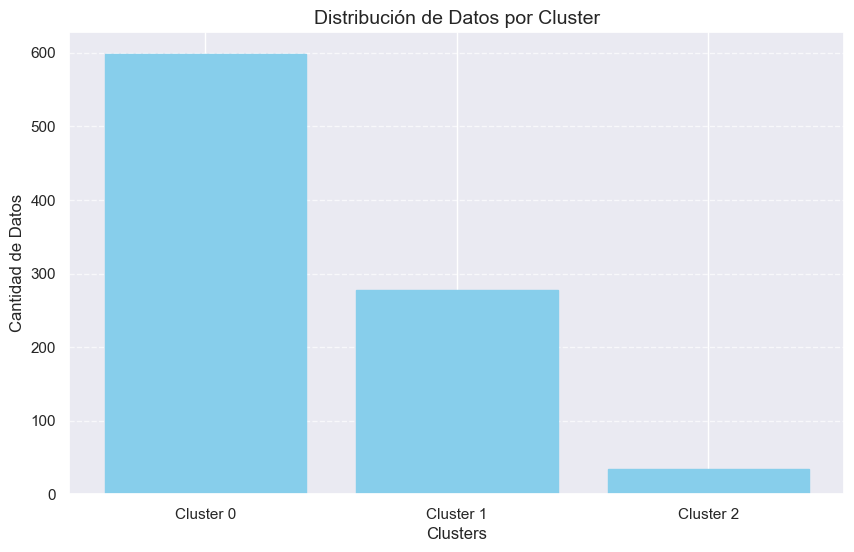

Tamaño de cada cluster:
0:   598 (65.79%)
1:   277 (30.47%)
2:    34 ( 3.74%)


In [64]:
barras_clusters(clusters_km)

clusters_dataframe_km = pd.DataFrame(clusters_km,index=X_km.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters_dataframe_km['cluster'].value_counts()
size = size.sort_index()

for i,c in enumerate(size):
   print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters_dataframe_km)))

In [115]:
# Print results as a table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

Algorithm  Number of Clusters  Execution Time (s)  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
   KMeans                   4            0.045696          0.581761              1232.329278              0.584848
   KMeans                   5            0.045446          0.528697              1196.192314              0.615417
   KMeans                   6            0.041915          0.536443              1258.035089              0.633838
   KMeans                   7            0.042027          0.539521              1337.889849              0.590553
   KMeans                   8            0.044403          0.489173              1430.222360              0.654975


#### HEATMAP KMEANS

<Figure size 640x480 with 0 Axes>

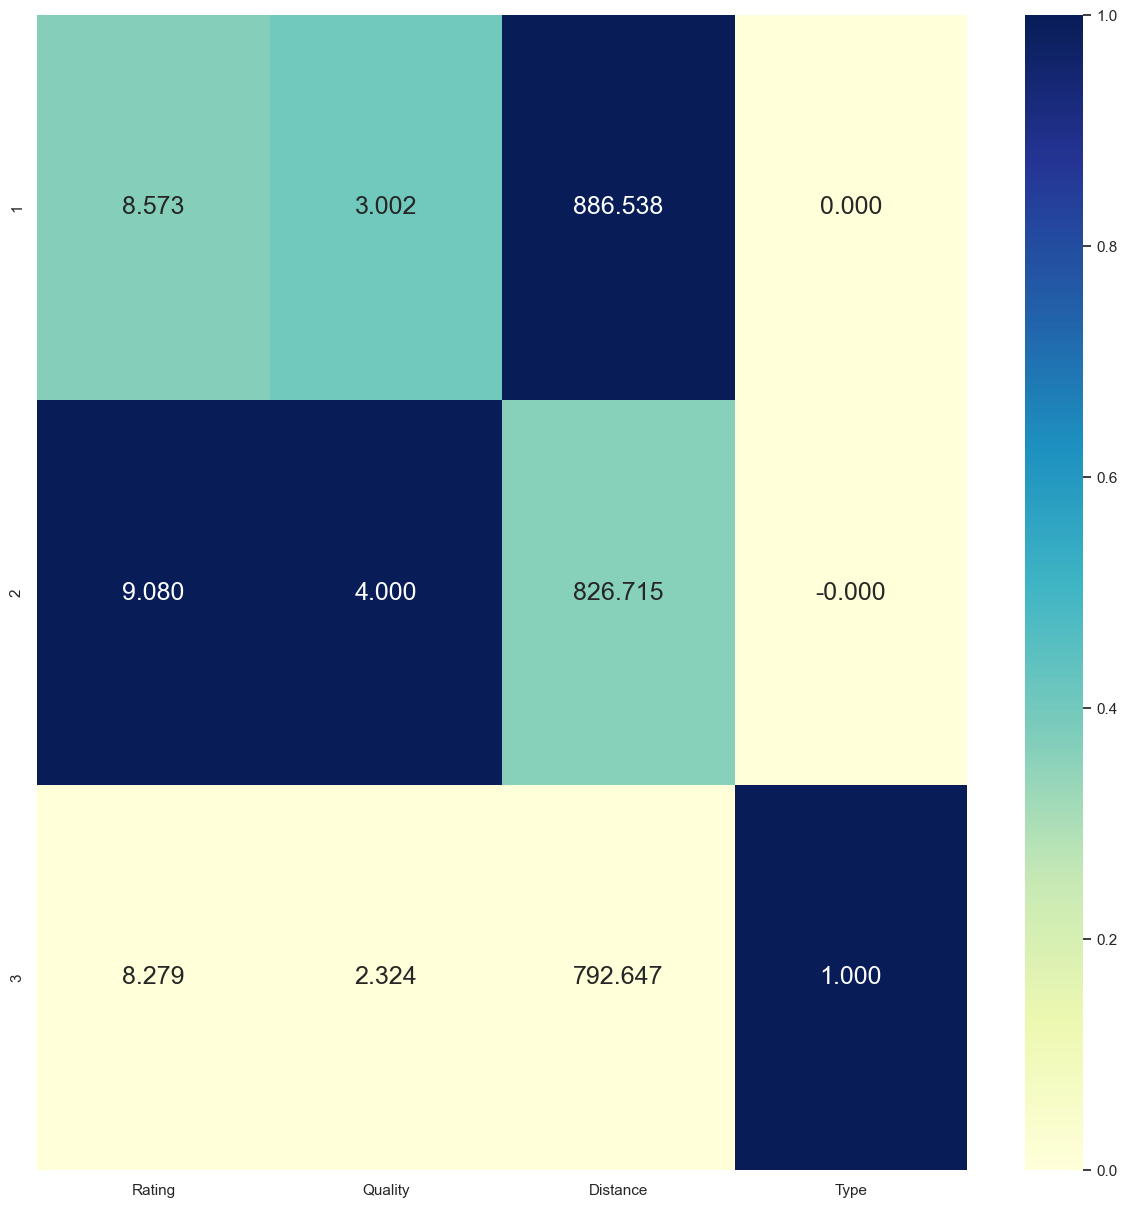

In [66]:
# Obtener los centros normalizados
centers_normalized_km = pd.DataFrame(kmeans.cluster_centers_, columns=list(X_km))
centers_desnormalized_km = denorm_from_zero_one(centers_normalized_km, min_vals, max_vals)
gen_heatmap(centers_desnormalized_km)

#### SCATTER MATRIX KMEANS

<Figure size 640x480 with 0 Axes>

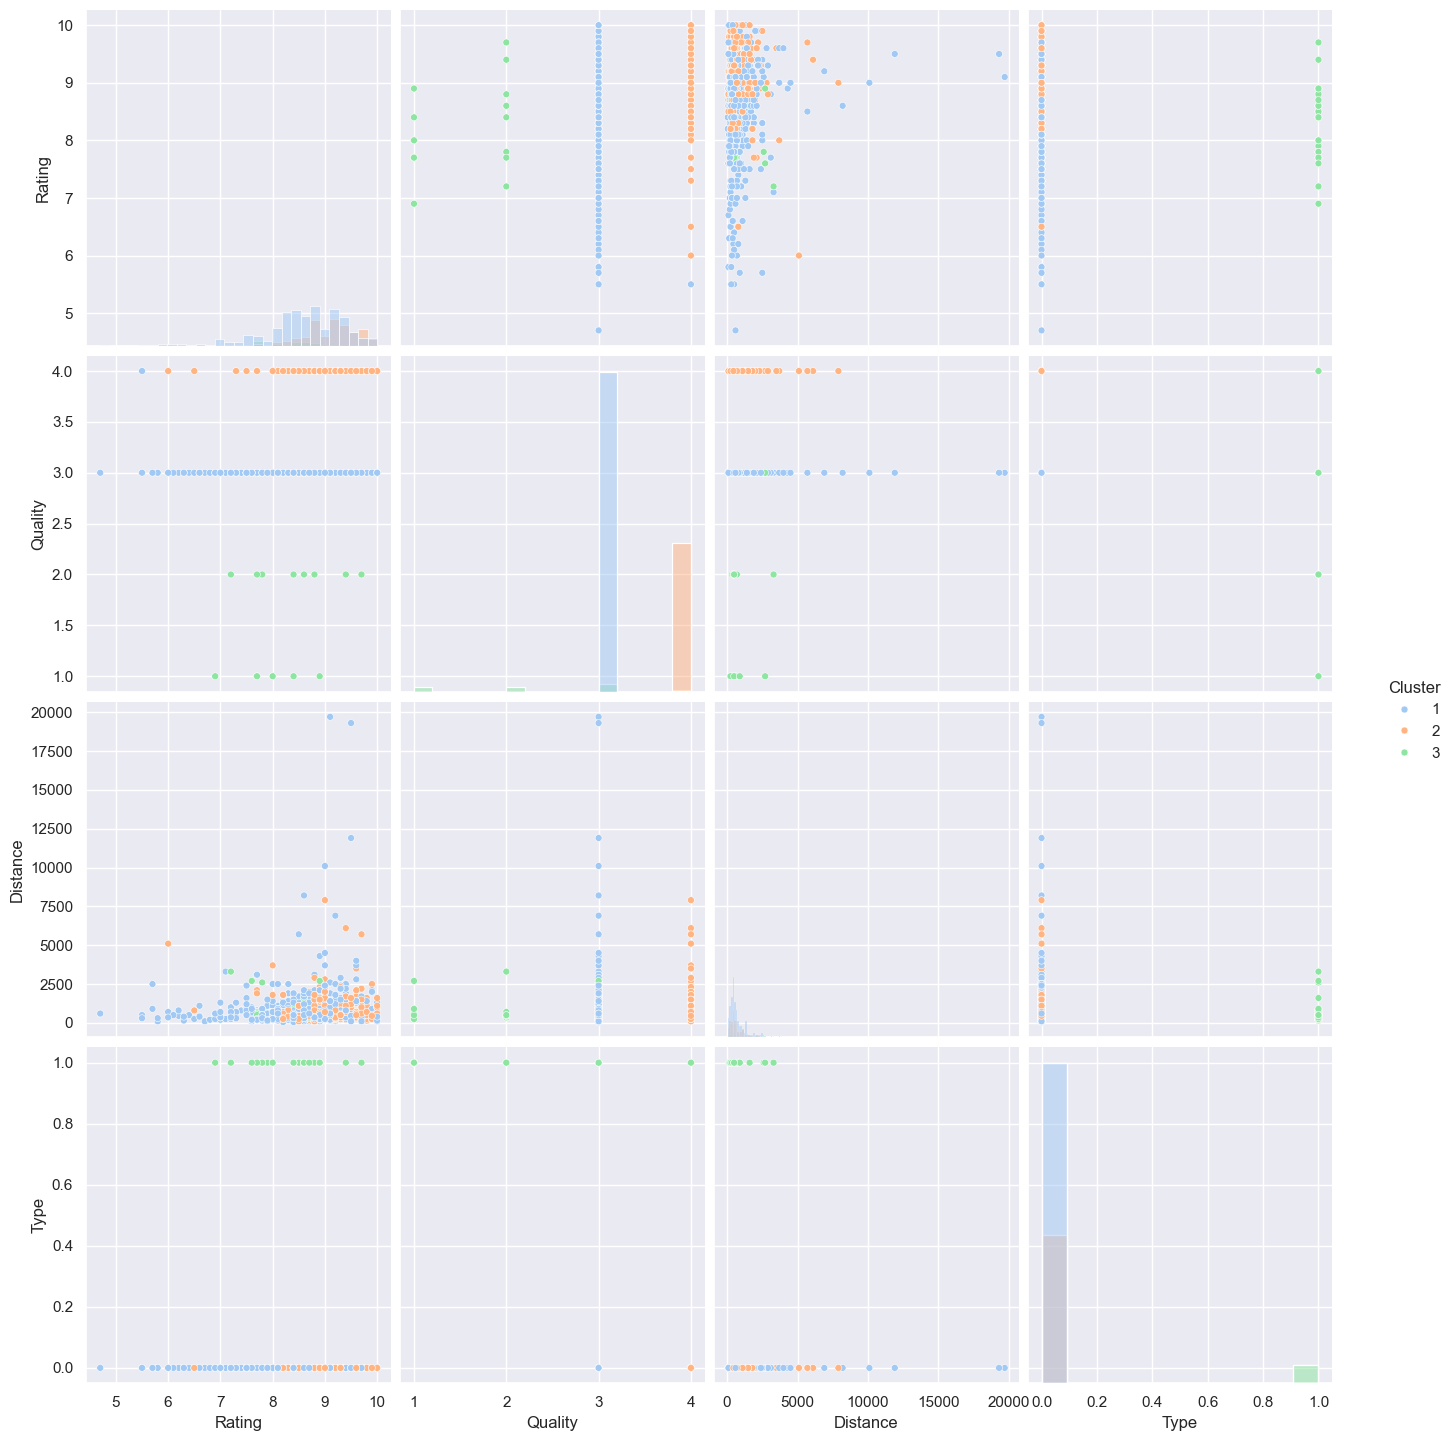

In [67]:
data_desnormalized = denorm_from_zero_one(X_km, min_vals, max_vals)
data_desnormalized['Cluster'] = clusters_km
gen_pairplot(data_desnormalized)

#### BOXPLOT

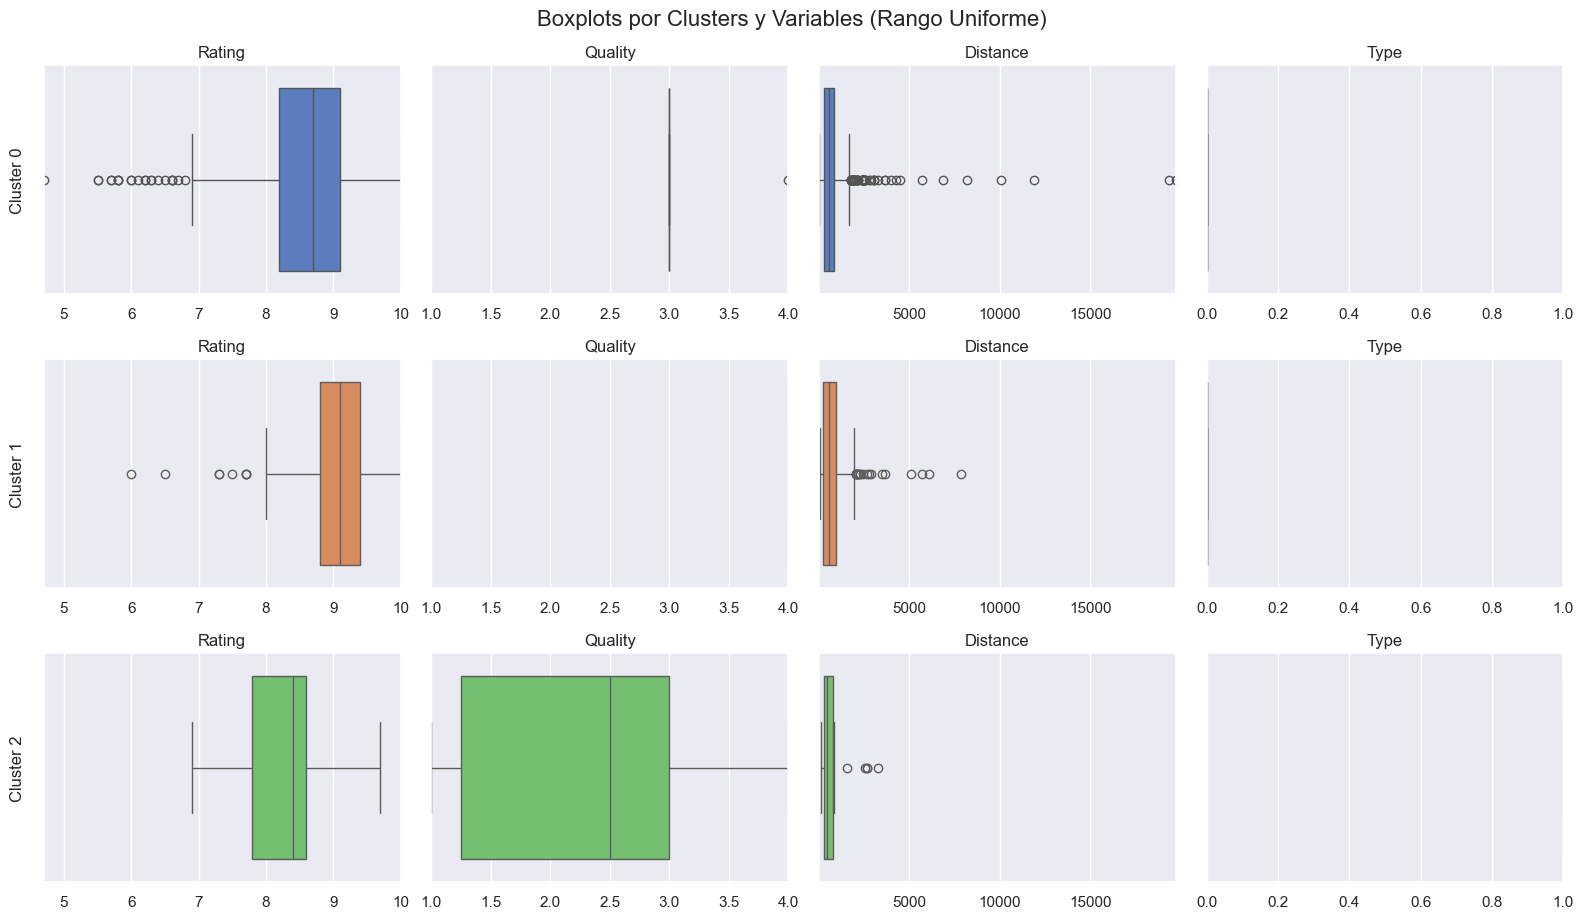

In [90]:
gen_boxplot(data_desnormalized, clusters_km)

## Mean Shift

In [166]:
X_meanshift = X

bandwidth = 0.4

meanshift = MeanShift(bandwidth = bandwidth)
print("Ejecutando MeanShift")
start_time = time.time()
clusters_meanshift = meanshift.fit_predict(X)
end_time = time.time()

n, silh, ch, db = generar_metricas(X_meanshift, clusters_meanshift)

results.append({
    "Algorithm": "MeanShift",
    "Number of Clusters": n,
    "Bandwidth": bandwidth,
    "Execution Time (s)": end_time - start_time,
    "Silhouette Score": silh,
    "Calinski-Harabasz Index": ch,
    "Davies-Bouldin Index": db
})

Ejecutando MeanShift
Silhouette
Calinski_harabasz
Davies_Bouldin


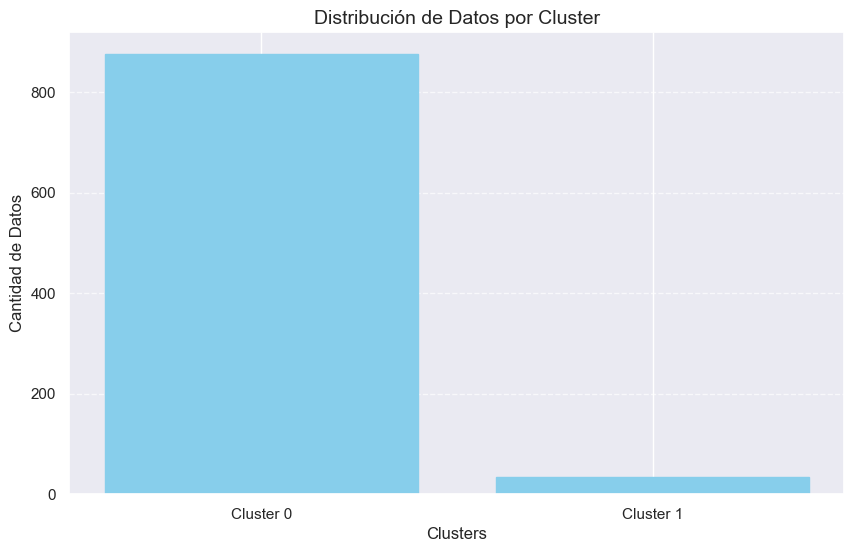

Tamaño de cada cluster:
0:   875 (96.26%)
1:    34 ( 3.74%)


In [167]:
barras_clusters(clusters_meanshift)

clusters_dataframe_meanshift = pd.DataFrame(clusters_meanshift,index=X_meanshift.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters_dataframe_meanshift['cluster'].value_counts()
size=size.sort_index()

for i,c in enumerate(size):
   print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters_dataframe_meanshift)))

In [162]:
# Print results as a table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

Algorithm  Number of Clusters  Bandwidth  Execution Time (s)  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
MeanShift                  25       0.10            2.372543          0.432650               302.040500              0.426974
MeanShift                  16       0.15            1.897548          0.501099               359.912500              0.582948
MeanShift                  10       0.20            1.243589          0.598520               533.454556              0.545246
MeanShift                   7       0.25            1.288494          0.599070               503.319107              0.550929
MeanShift                   4       0.35            1.436116          0.659300               291.700568              0.588213
MeanShift                   2       0.40            1.232512          0.758175               695.094093              0.488792


#### HEATMAP MEAN SHIFT

<Figure size 640x480 with 0 Axes>

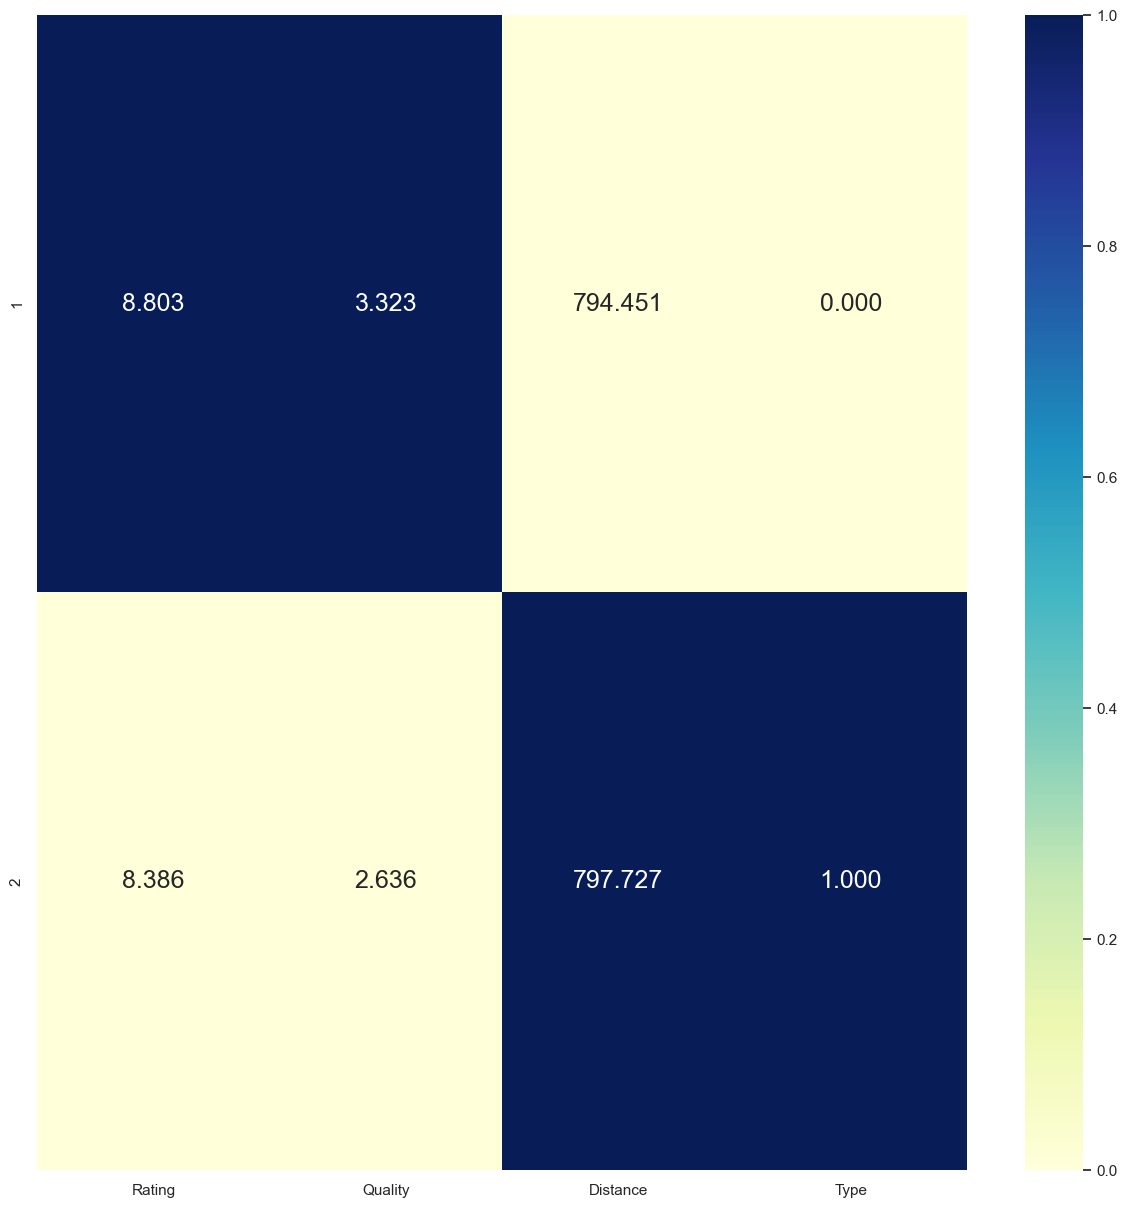

In [171]:
# Obtener los centros normalizados
centers_normalized_meanshift = pd.DataFrame(meanshift.cluster_centers_, columns=list(X_meanshift))
centers_desnormalized_meanshift = denorm_from_zero_one(centers_normalized_meanshift, min_vals, max_vals)
gen_heatmap(centers_desnormalized_meanshift)

#### SCATTER MATRIX MEANSHIFT

<Figure size 640x480 with 0 Axes>

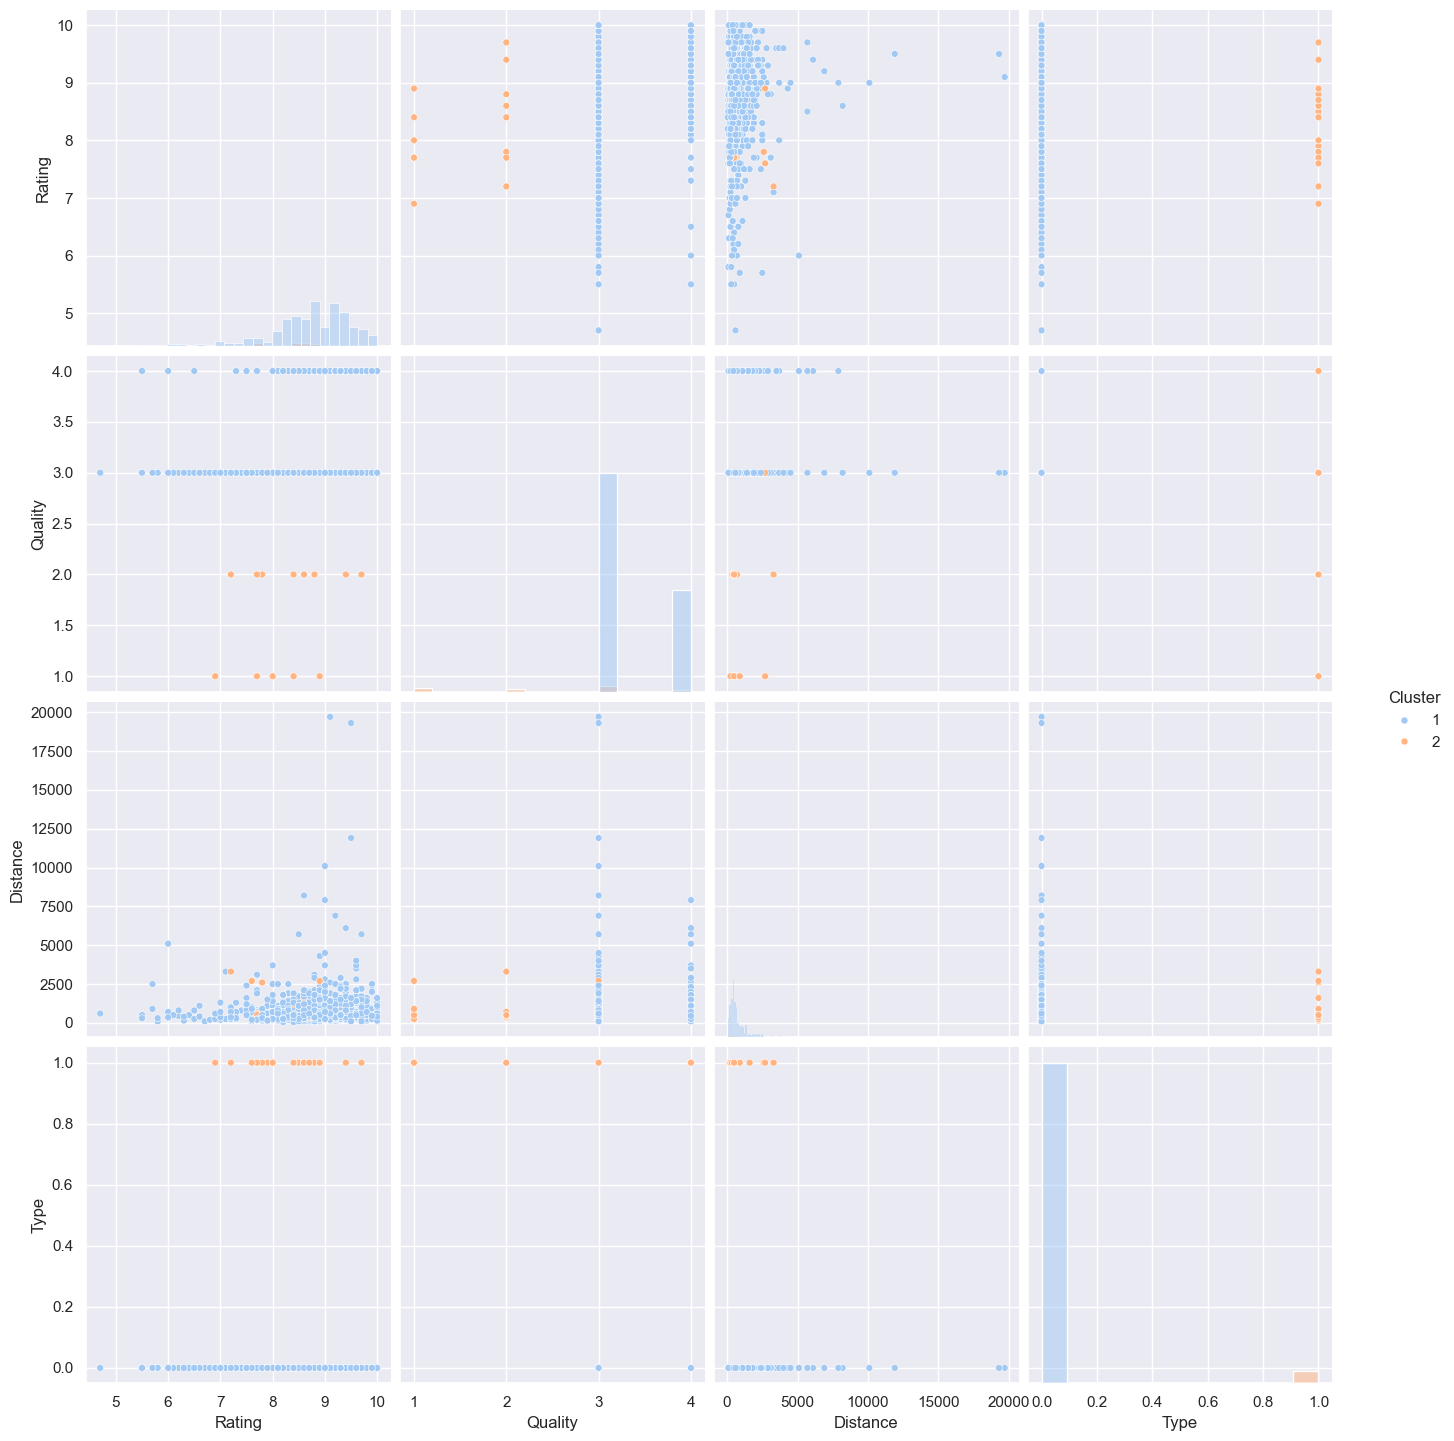

In [168]:
data_desnormalized_meanshift = denorm_from_zero_one(X_meanshift, min_vals, max_vals)
data_desnormalized_meanshift['Cluster'] = clusters_meanshift
gen_pairplot(data_desnormalized_meanshift)

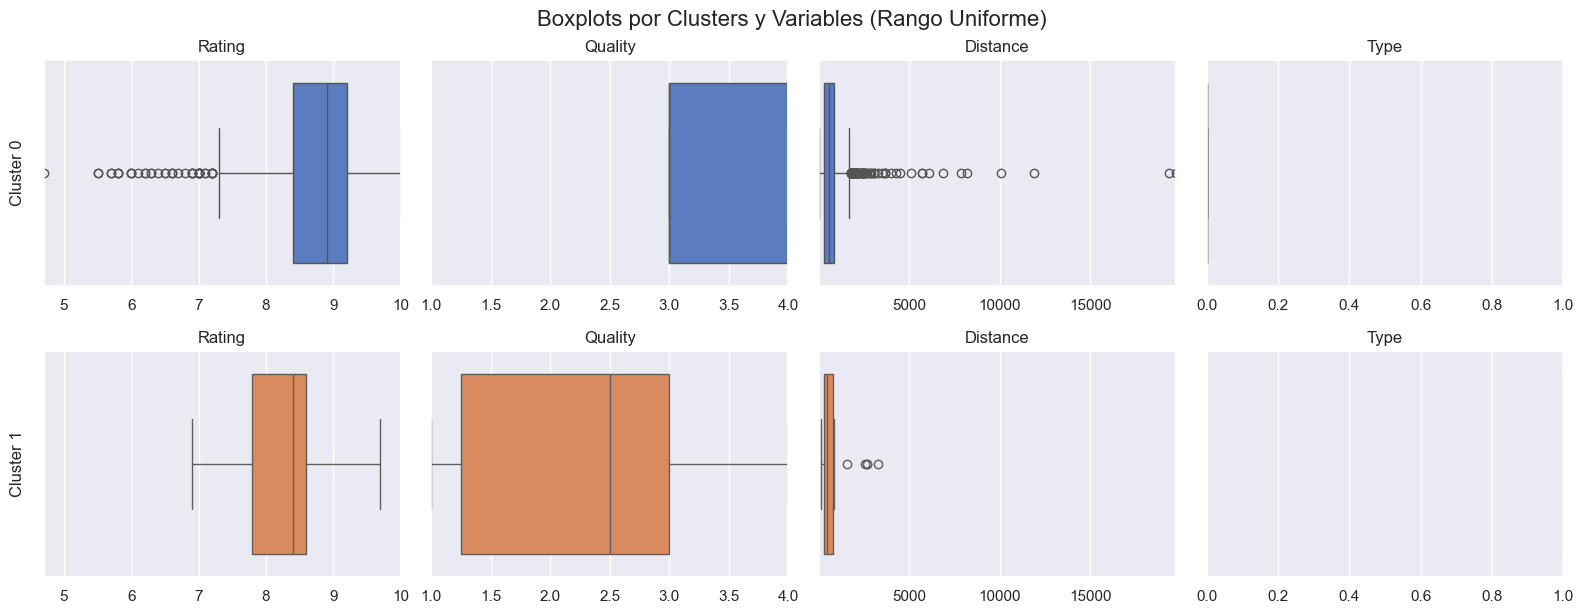

In [169]:
gen_boxplot(data_desnormalized_meanshift, clusters_meanshift)

## DBSCAN

In [211]:
X_dbscan = X

print("Ejecutando DBSCAN")
dbscan = DBSCAN(eps=0.4, min_samples=5, algorithm="ball_tree", n_jobs=-1)
start_time = time.time()
clusters_dbscan = dbscan.fit_predict(X_dbscan)
end_time = time.time()

n, silh, ch, db = generar_metricas(X_dbscan, clusters_dbscan)

results.append({
    "Algorithm": "DBSCAN",
    "Number of Clusters": n,
    "Execution Time (s)": end_time - start_time,
    "Silhouette Score": silh,
    "Calinski-Harabasz Index": ch,
    "Davies-Bouldin Index": db
})

Ejecutando DBSCAN
Silhouette
Calinski_harabasz
Davies_Bouldin


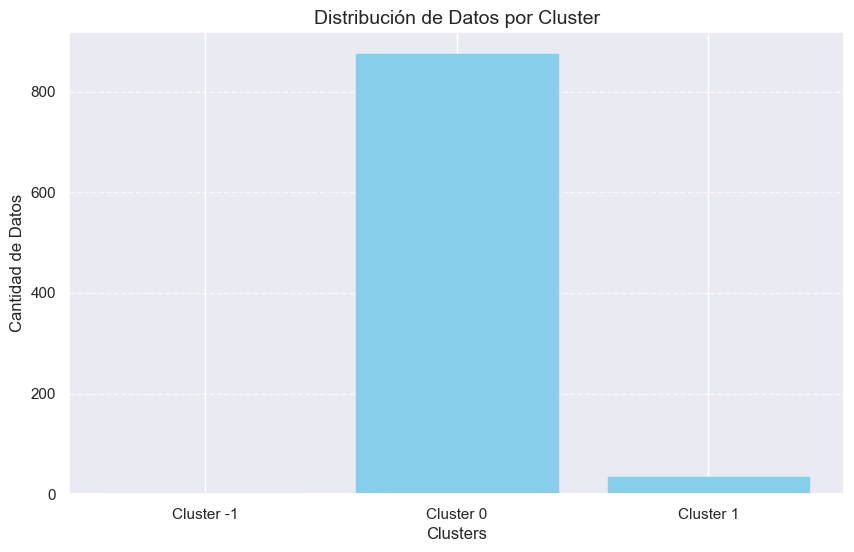

Tamaño de cada cluster:
0:     1 ( 0.11%)
1:   874 (96.15%)
2:    34 ( 3.74%)


In [212]:
barras_clusters(clusters_dbscan)

clusters_df_dbscan = pd.DataFrame(clusters_dbscan,index=X_dbscan.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters_df_dbscan['cluster'].value_counts()
size = size.sort_index()

for i,c in enumerate(size):
   print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters_df_dbscan)))

In [75]:
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

Algorithm  Number of Clusters  Execution Time (s)  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
   KMeans                   3            0.043509          0.591038              1073.119447              0.556830
MeanShift                   7            1.170733          0.599070               503.319107              0.550929
   DBSCAN                   2            0.045034          0.724710               363.168661              0.399455


#### HEATMAP DBSCAN

<Figure size 640x480 with 0 Axes>

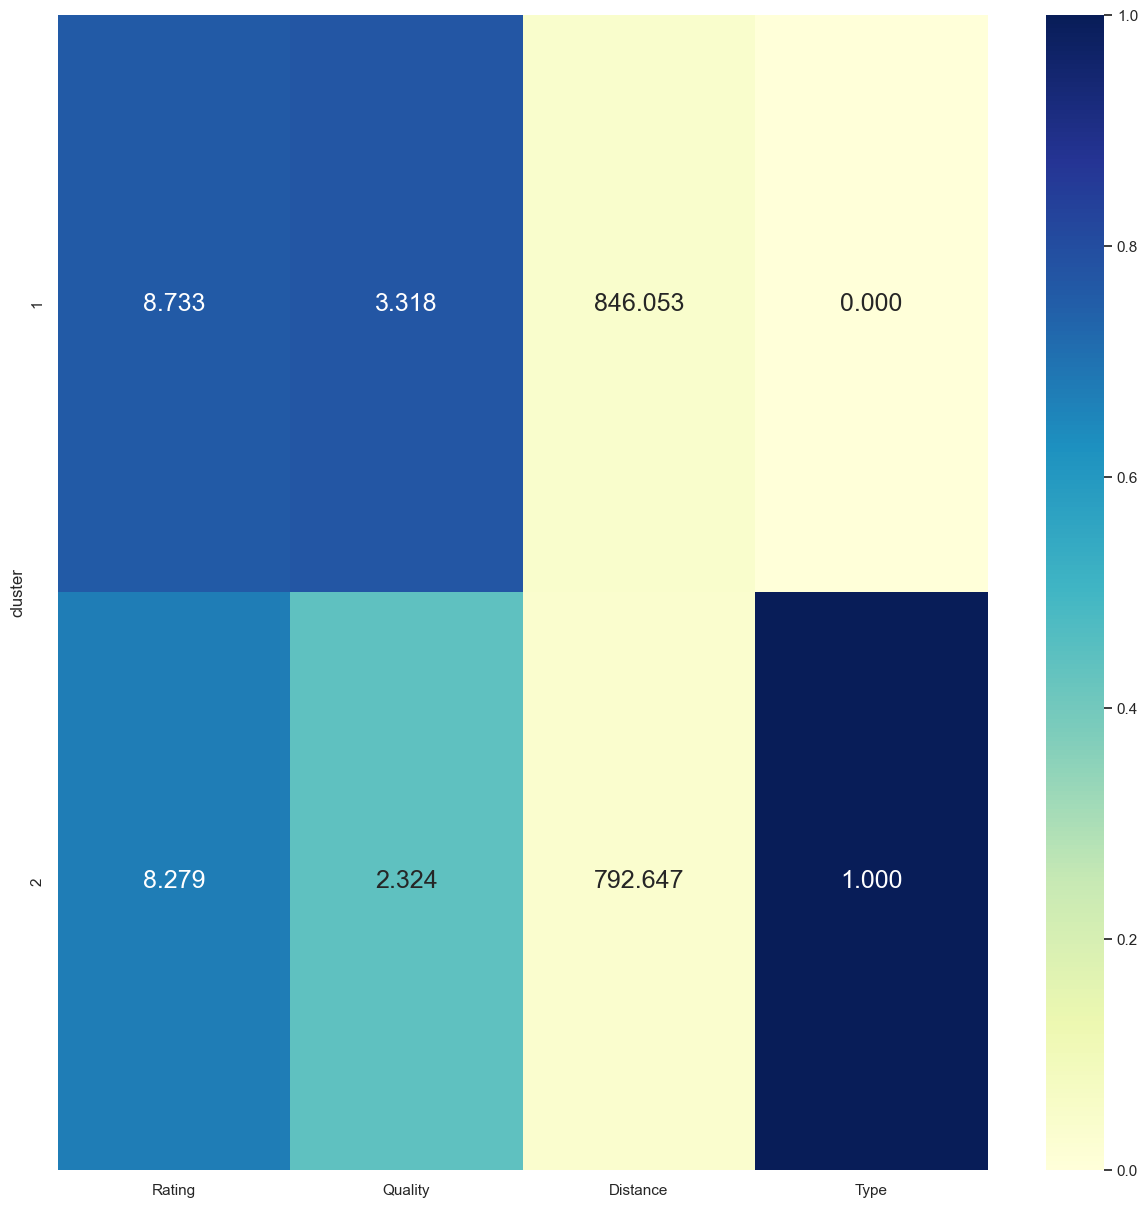

In [76]:
gen_heatmap_2(X_dbscan, clusters_dbscan, method="mean")

#### SCATTER MATRIX DBSCAN

<Figure size 640x480 with 0 Axes>

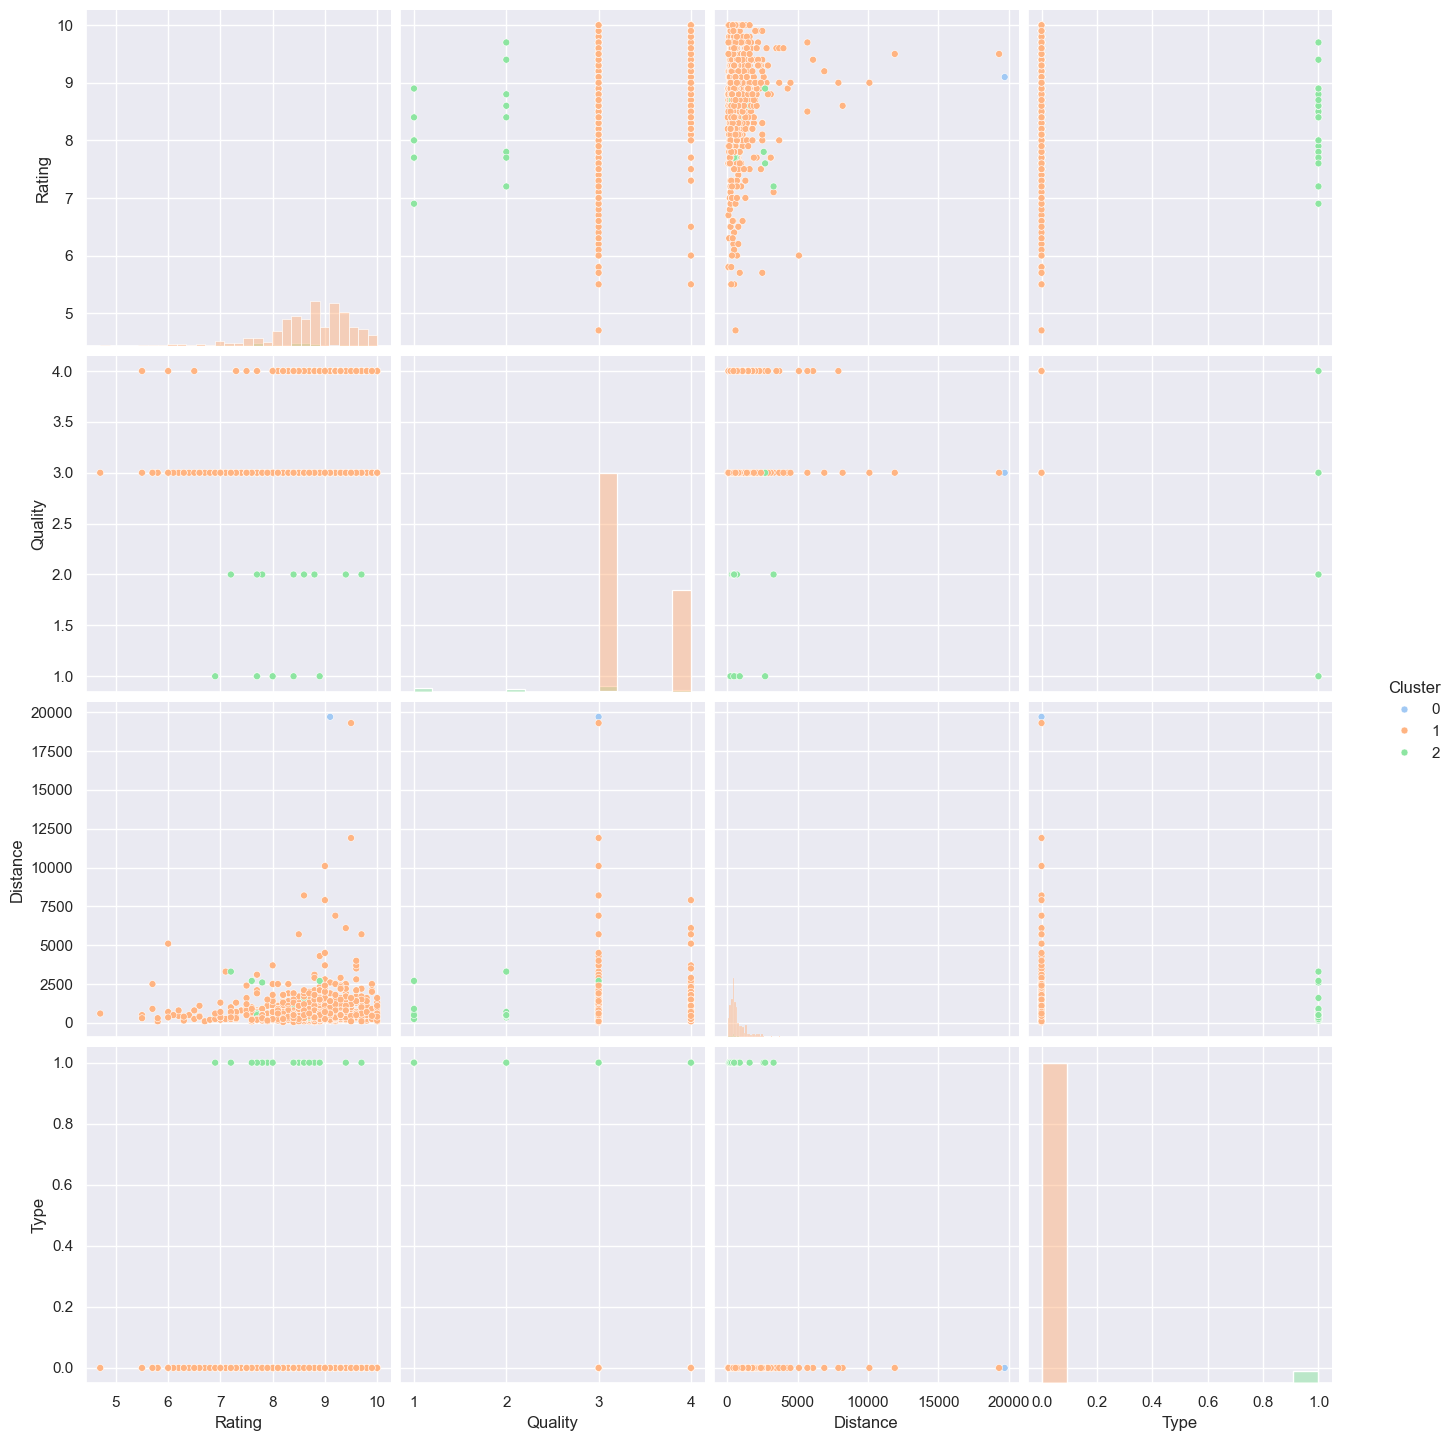

In [77]:
data_desnormalized_dbscan = denorm_from_zero_one(X_dbscan, min_vals, max_vals)
data_desnormalized_dbscan['Cluster'] = clusters_dbscan
gen_pairplot(data_desnormalized_dbscan)

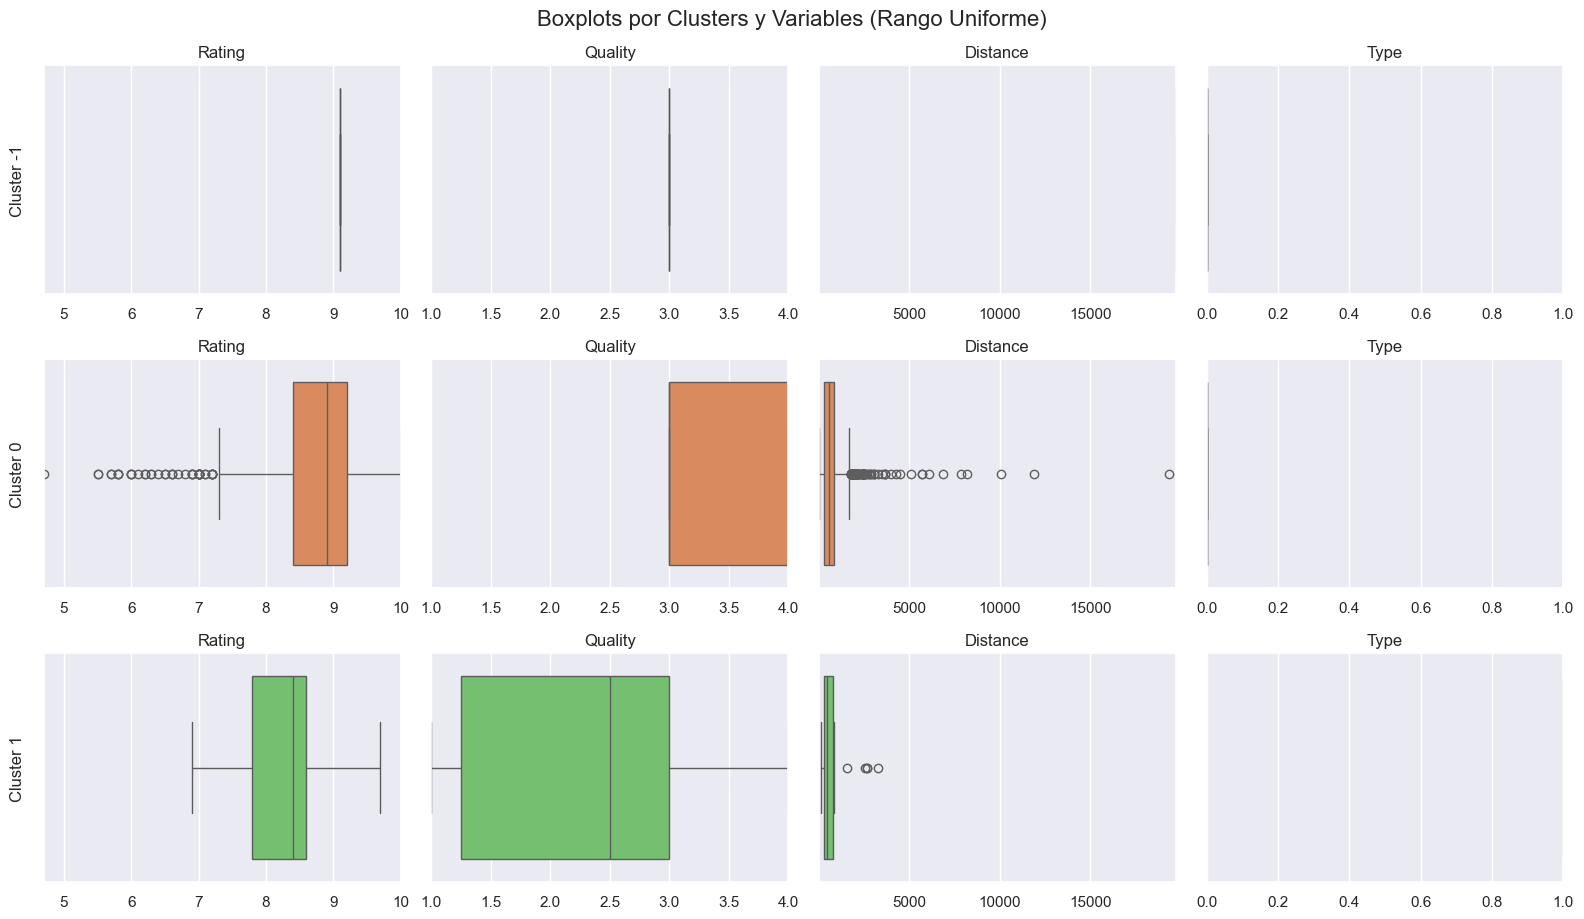

In [213]:
gen_boxplot(data_desnormalized_dbscan, clusters_dbscan)

## BIRCH

In [247]:
X_birch = X

print("Ejecutando BIRCH")
birch = Birch(branching_factor=25, threshold=0.15, n_clusters=3)
start_time = time.time()
clusters_birch = birch.fit_predict(X_birch)
end_time = time.time()

n, silh, ch, db = generar_metricas(X_birch, clusters_birch)

results.append({
    "Algorithm": "BIRCH",
    "Number of Clusters": n,
    "Execution Time (s)": end_time - start_time,
    "Silhouette Score": silh,
    "Calinski-Harabasz Index": ch,
    "Davies-Bouldin Index": db
})

Ejecutando BIRCH
Silhouette
Calinski_harabasz
Davies_Bouldin


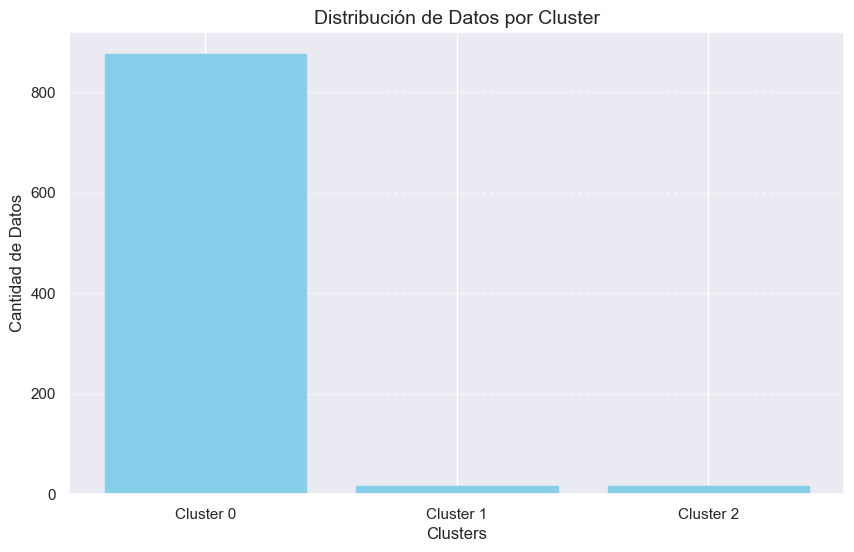

Tamaño de cada cluster:
0:   875 (96.26%)
1:    17 ( 1.87%)
2:    17 ( 1.87%)


In [248]:
barras_clusters(clusters_birch)

clusters_df_birch = pd.DataFrame(clusters_birch,index=X_birch.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters_df_birch['cluster'].value_counts()
size = size.sort_index()

for i,c in enumerate(size):
   print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters_df_birch)))

In [226]:
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

Algorithm  Number of Clusters  Execution Time (s)  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
   DBSCAN                   2            0.027612          0.724710               363.168661              0.399455
    BIRCH                   3            0.014564          0.737348               396.346176              0.523836
    BIRCH                   3            0.021447          0.529692               460.682650              0.560361
    BIRCH                   5            0.021708          0.516068               291.779116              0.672038
    BIRCH                   1            0.015964               NaN                      NaN                   NaN
    BIRCH                   3            0.013676          0.729481               364.945838              0.506508


#### HEATMAP BIRCH

<Figure size 640x480 with 0 Axes>

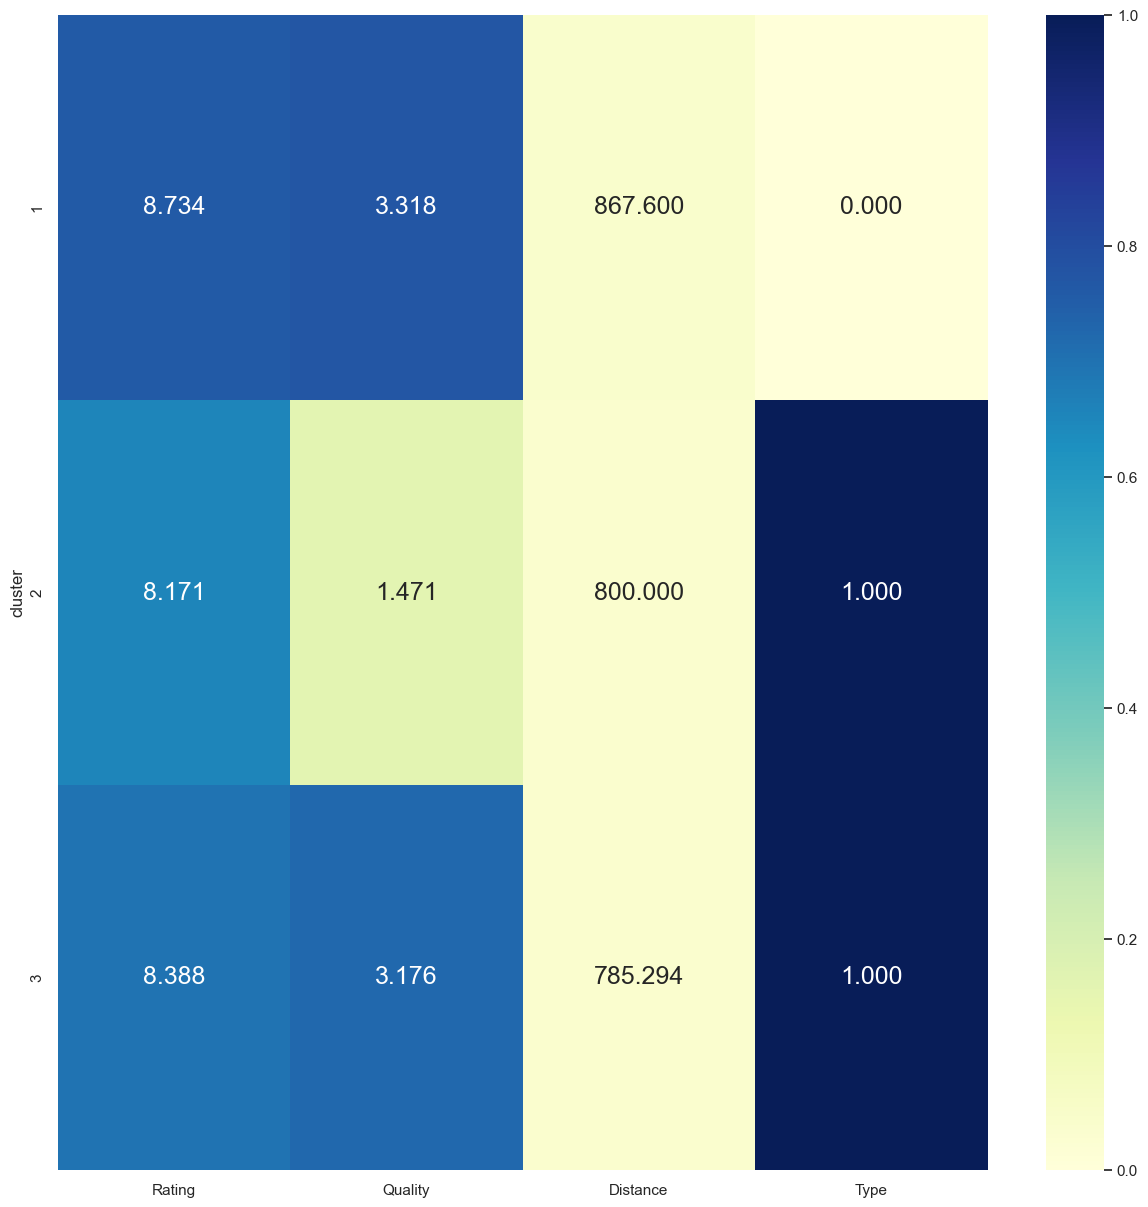

In [81]:
gen_heatmap_2(X_birch, clusters_birch, method="mean")

#### SCATTER MATRIX BIRCH

<Figure size 640x480 with 0 Axes>

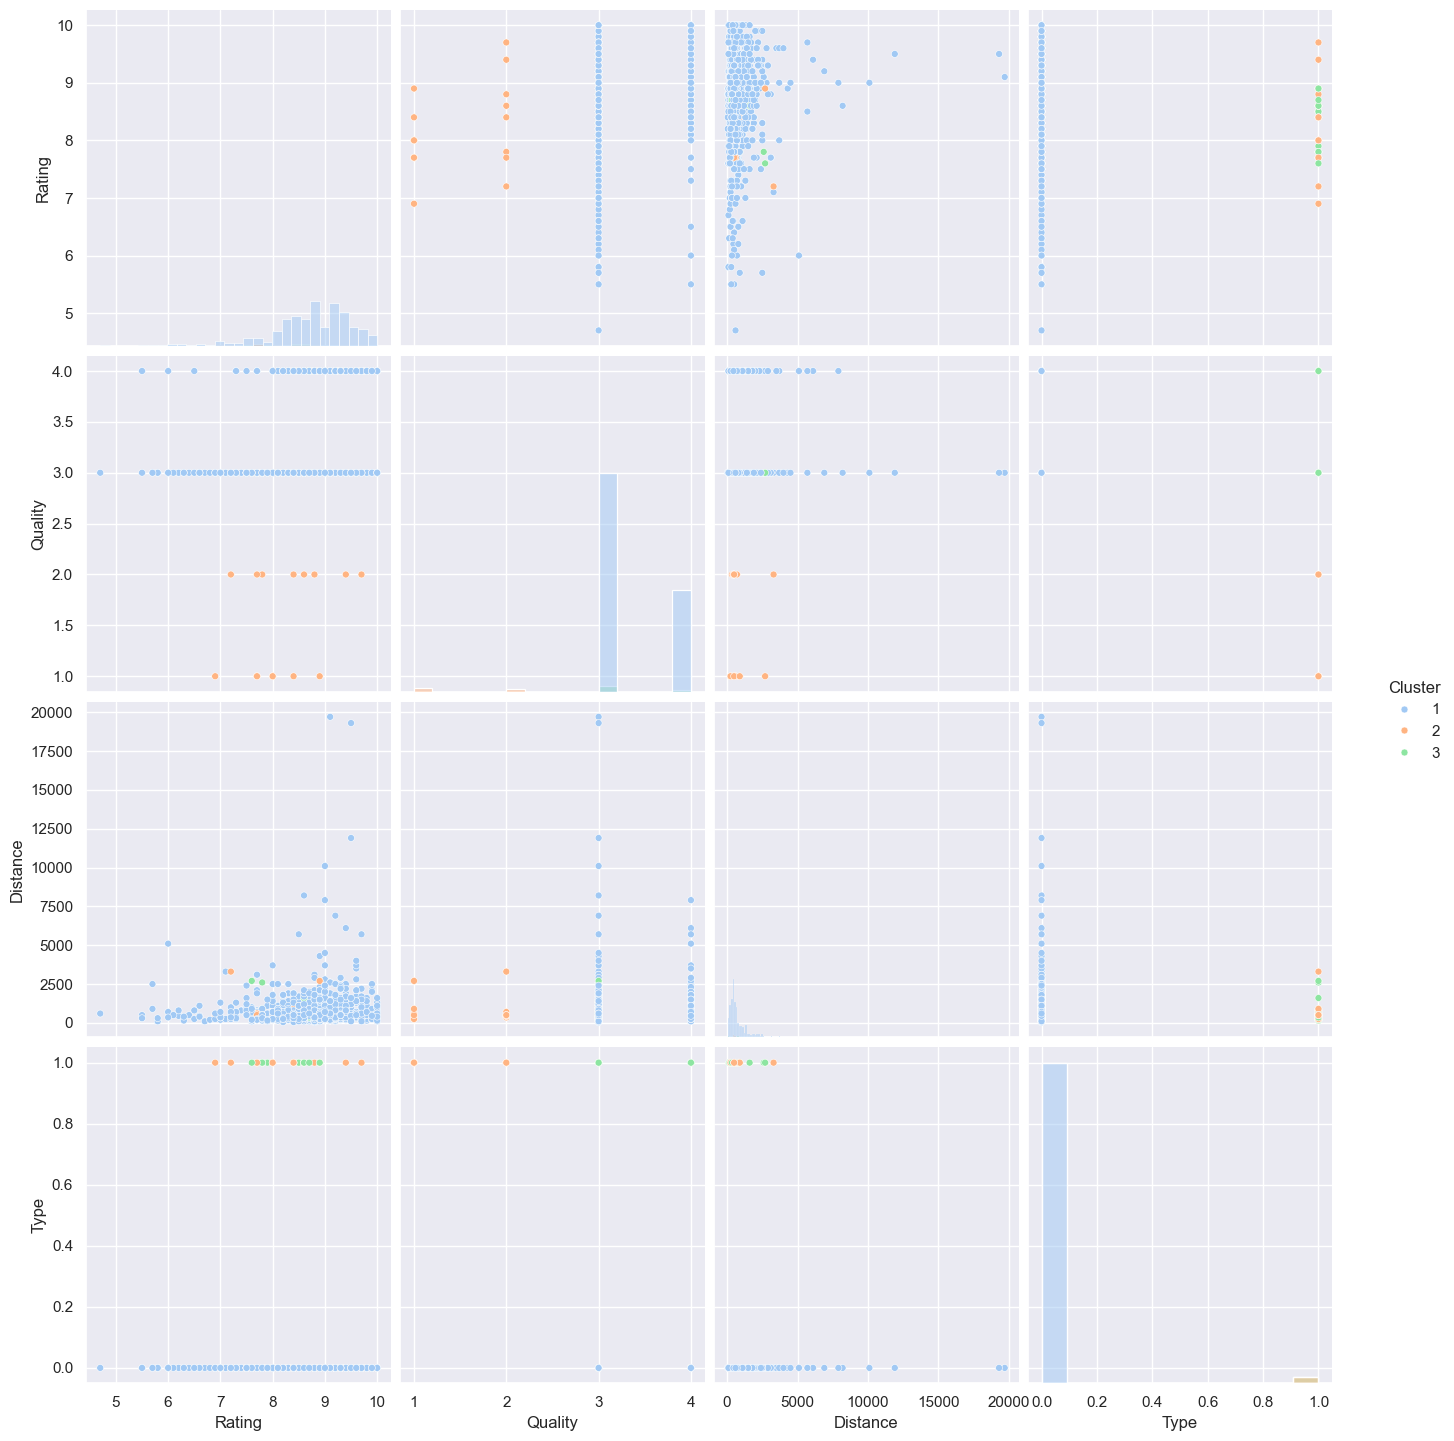

In [82]:
data_desnormalized_birch = denorm_from_zero_one(X_birch, min_vals, max_vals)
data_desnormalized_birch['Cluster'] = clusters_birch
gen_pairplot(data_desnormalized_birch)

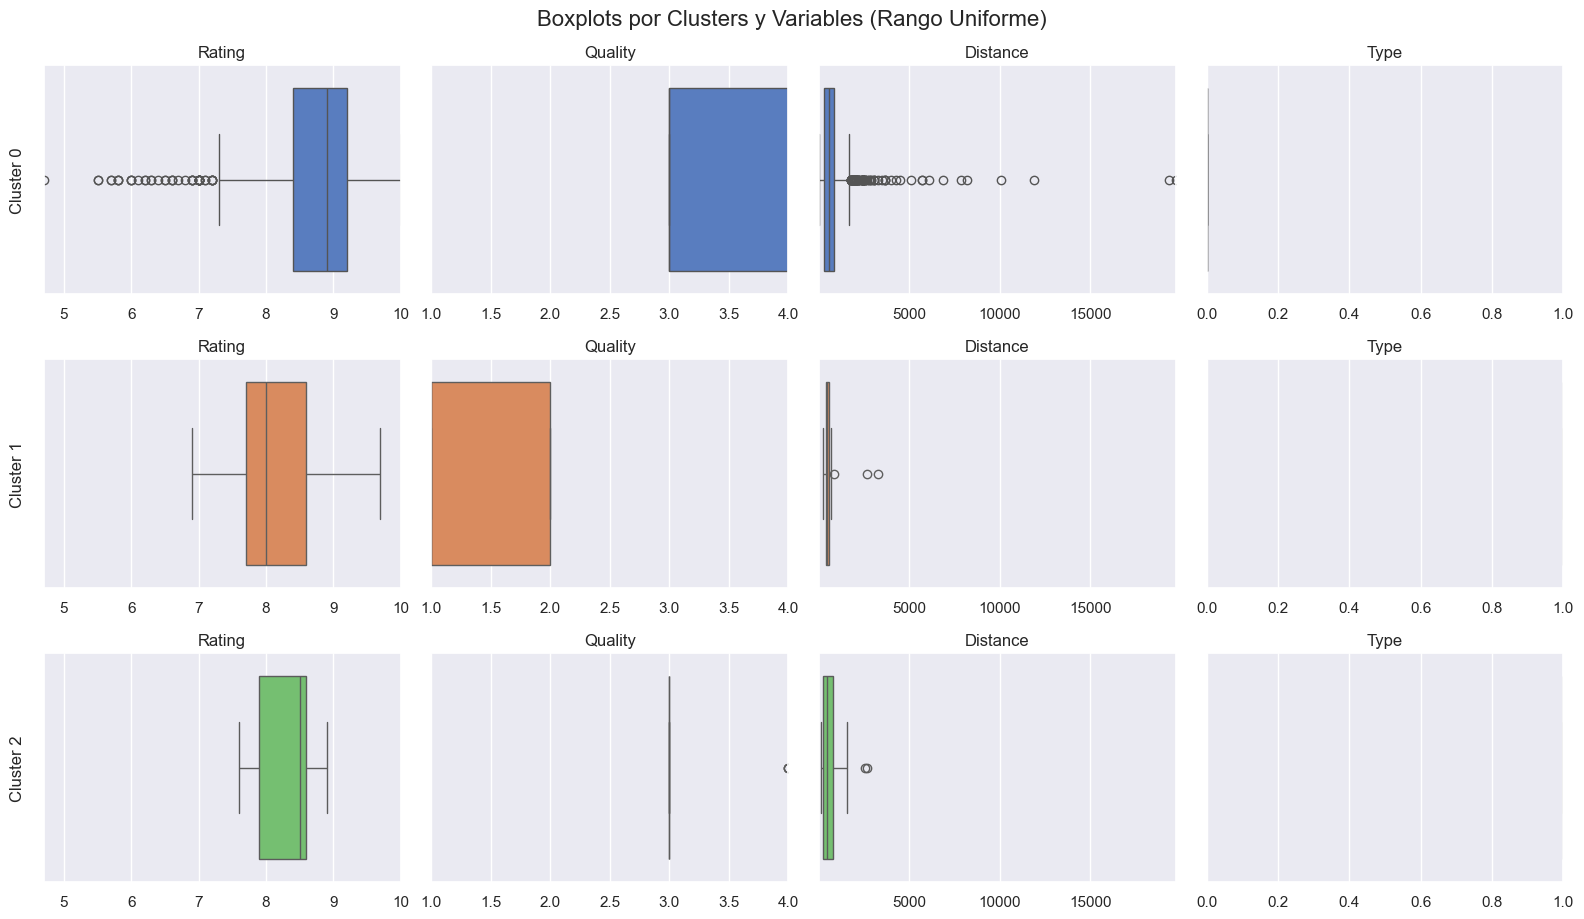

In [249]:
gen_boxplot(data_desnormalized_birch, clusters_birch)

## Algoritmo Jerárquico

In [83]:
X_jerarquico = X

enlace = "single"

print("Ejecutando algoritmo jerárquico")
jerarquico = AgglomerativeClustering(n_clusters=3, linkage=enlace, metric="euclidean")
start_time = time.time()
clusters_jerarquico = jerarquico.fit_predict(X_jerarquico)
end_time = time.time()

n, silh, ch, db = generar_metricas(X_jerarquico, clusters_jerarquico)

results.append({
    "Algorithm": "Jerárquico",
    "Number of Clusters": n,
    "Execution Time (s)": end_time - start_time,
    "Silhouette Score": silh,
    "Calinski-Harabasz Index": ch,
    "Davies-Bouldin Index": db
})

Ejecutando algoritmo jerárquico
Silhouette
Calinski_harabasz
Davies_Bouldin


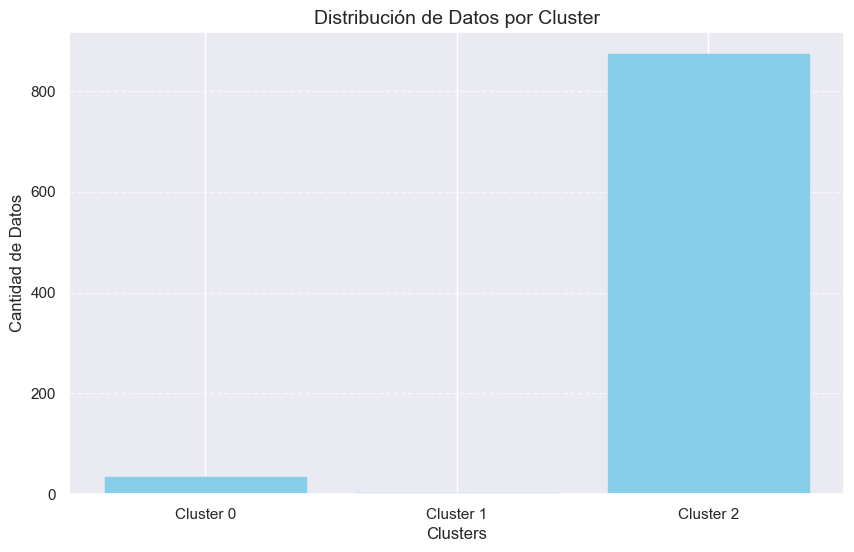

Tamaño de cada cluster:
0:    34 ( 3.74%)
1:     2 ( 0.22%)
2:   873 (96.04%)


In [84]:
barras_clusters(clusters_jerarquico)

clusters_df_jerarquico = pd.DataFrame(clusters_jerarquico,index=X_jerarquico.index,columns=['cluster'])

print("Tamaño de cada cluster:")
size=clusters_df_jerarquico['cluster'].value_counts()
size = size.sort_index()

for i,c in enumerate(size):
   print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters_df_jerarquico)))

In [85]:
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 Algorithm  Number of Clusters  Execution Time (s)  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index
    KMeans                   3            0.043509          0.591038              1073.119447              0.556830
 MeanShift                   7            1.170733          0.599070               503.319107              0.550929
    DBSCAN                   2            0.045034          0.724710               363.168661              0.399455
     BIRCH                   3            0.013812          0.737348               396.346176              0.523836
Jerárquico                   3            0.006722          0.727018               379.401065              0.408251


#### HEATMAP ENLACE SIMPLE

<Figure size 640x480 with 0 Axes>

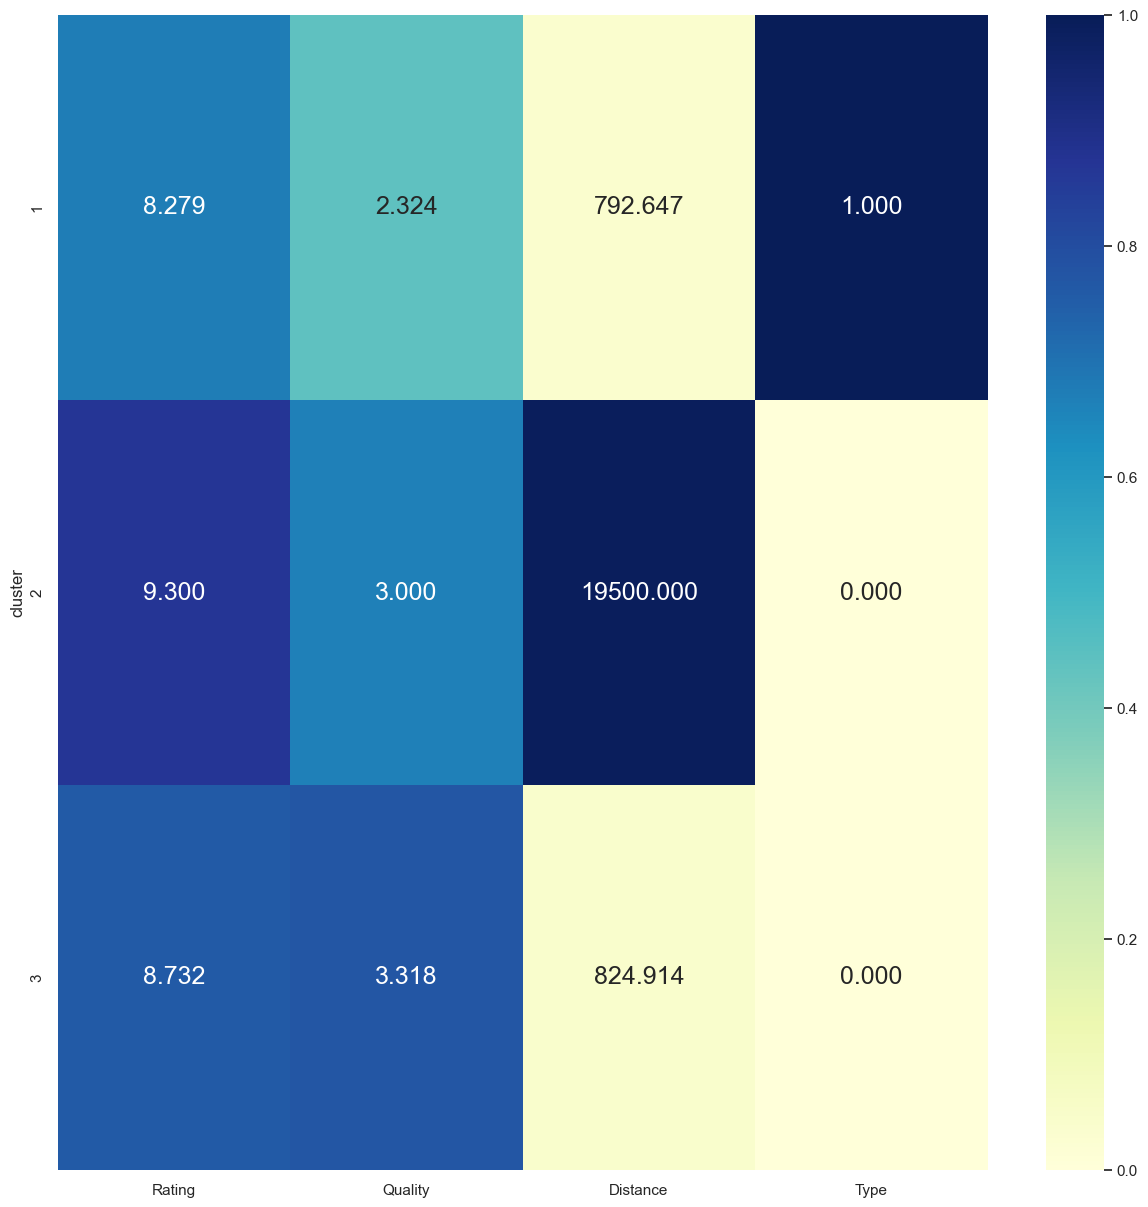

In [86]:
gen_heatmap_2(X_jerarquico, clusters_jerarquico, method="mean")

#### SCATTER MATRIX ENLACE SIMPLE

<Figure size 640x480 with 0 Axes>

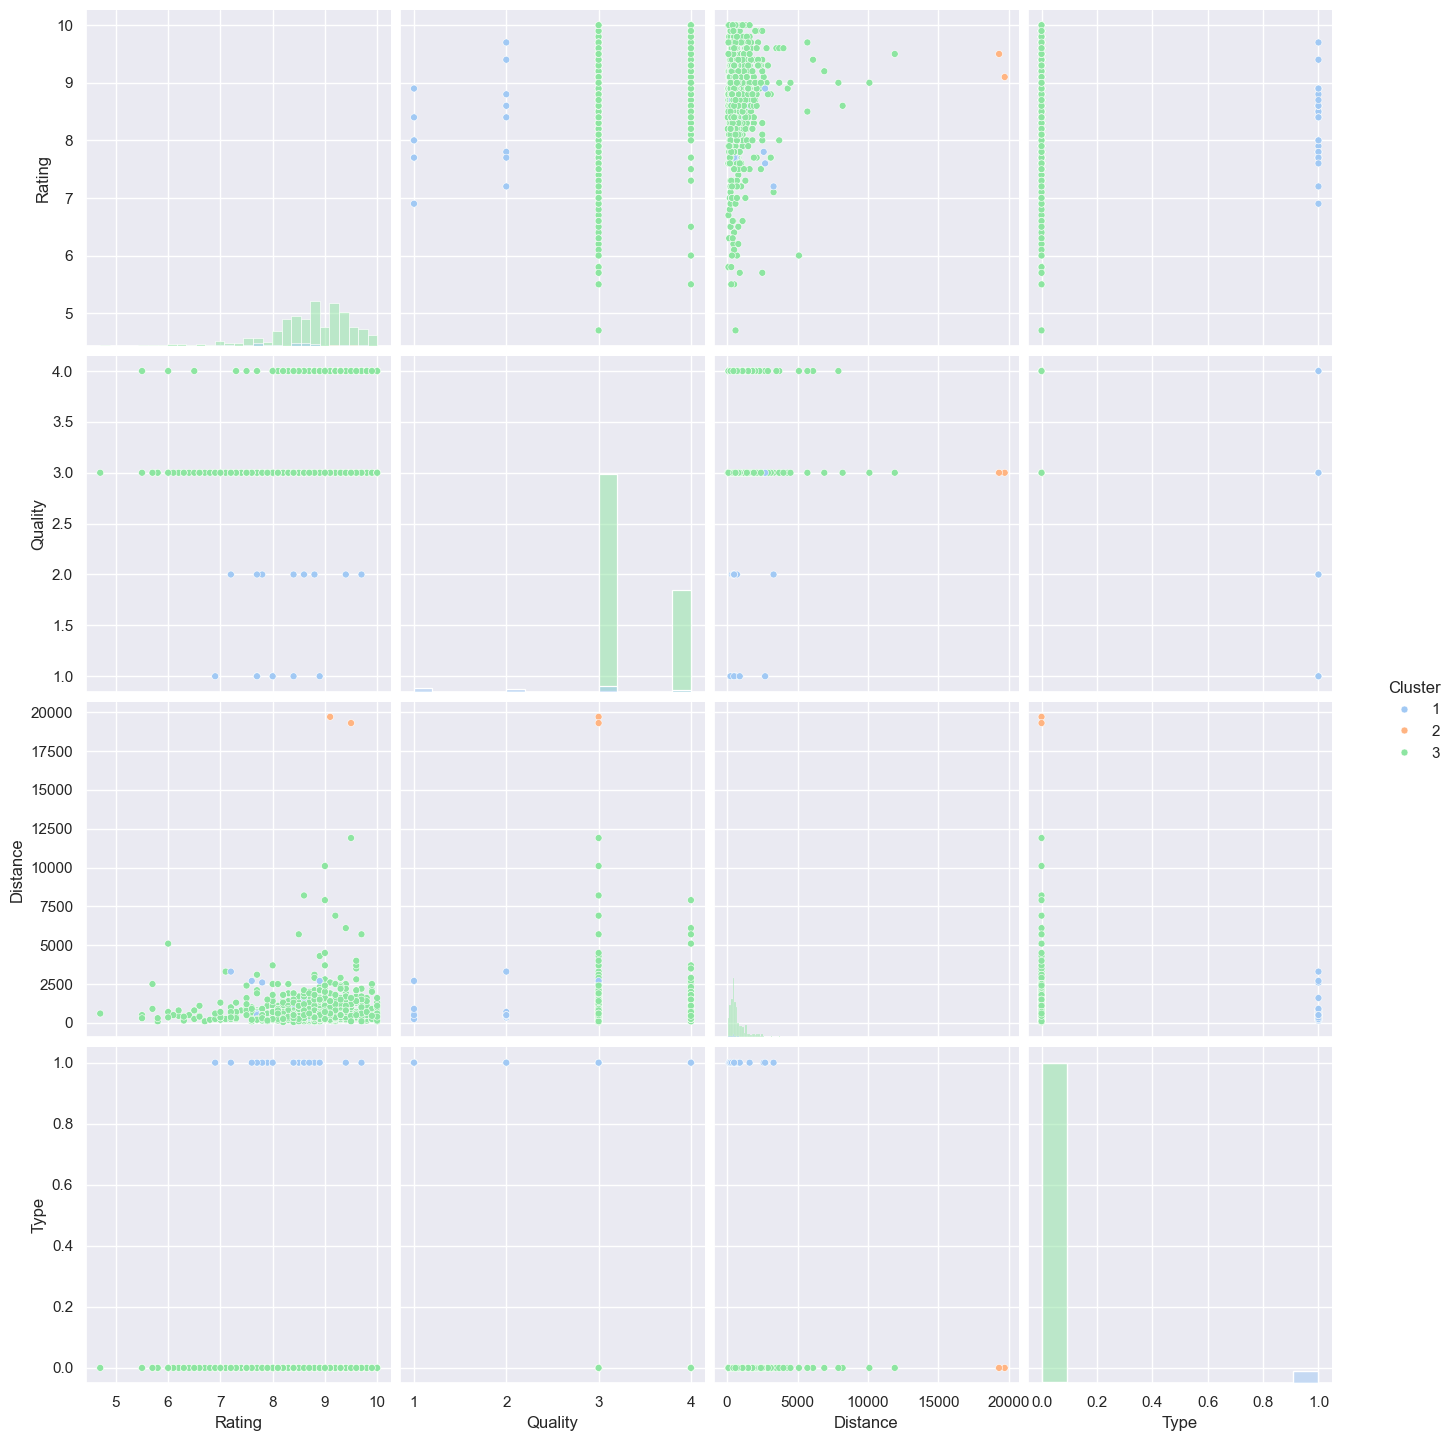

In [87]:
data_desnormalized_jerarquico = denorm_from_zero_one(X_jerarquico, min_vals, max_vals)
data_desnormalized_jerarquico['Cluster'] = clusters_jerarquico
gen_pairplot(data_desnormalized_jerarquico)

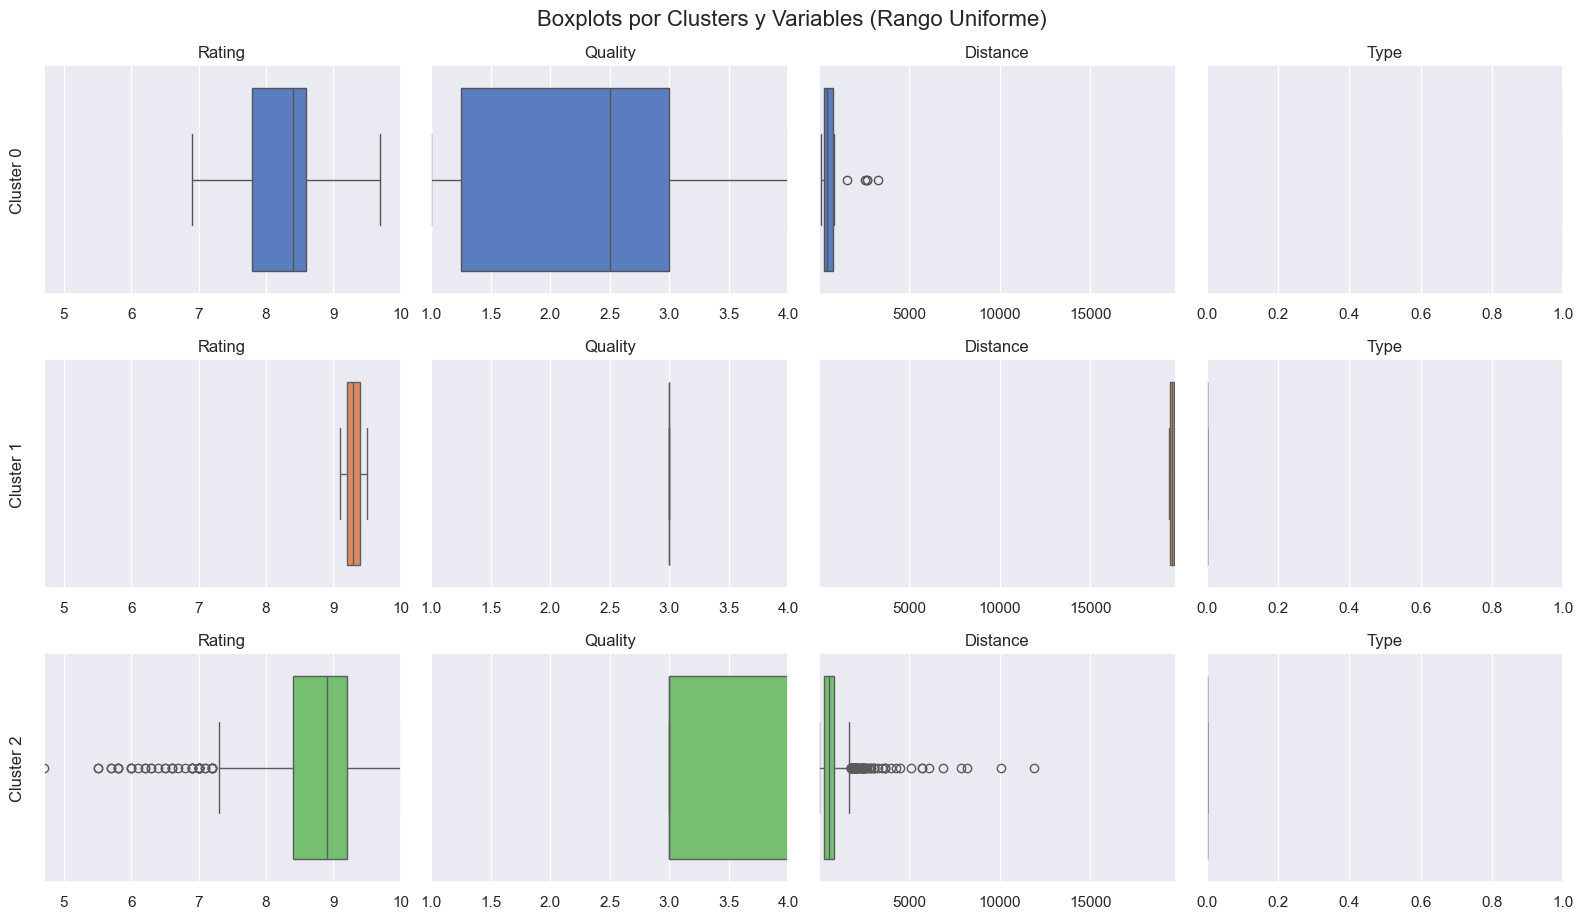

In [269]:
gen_boxplot(data_desnormalized_jerarquico, clusters_jerarquico)

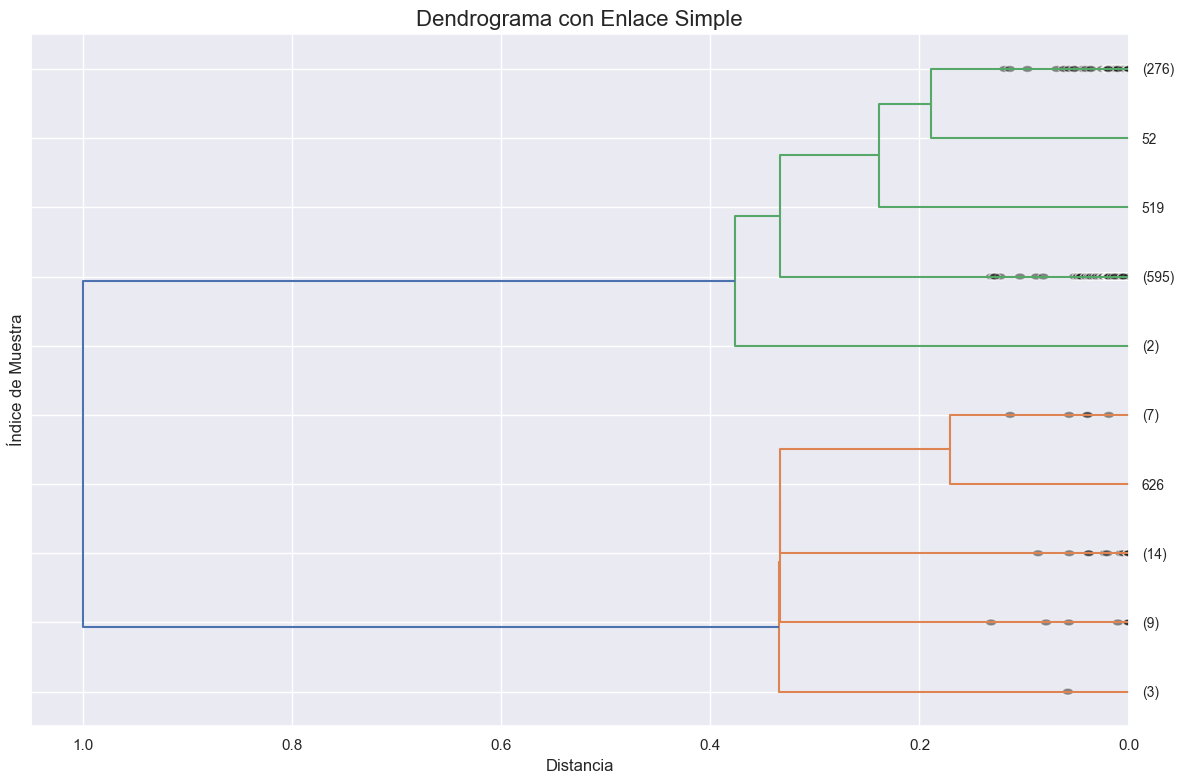

In [88]:
gen_dendogram(X_jerarquico)